# Sentiment Analysis Prototyping

Prototype code for ML-based sentiment analysis. Classification case pos/neutral/neg only.

In [1]:
import os, re, string, pickle, random

import numpy as np
import pandas as pd

import nltk
nltk.data.path.append("../data/external/nltk_data")
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem

import emoji

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve, ROCAUC

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23
random.seed(random_state)

## Loading

In [3]:
data_path = "/mnt/DATA/NRW2019 Dropbox/data 4good/CSVData"
fpath = os.path.join(data_path, "TestData", "forSentAnalysis.csv")

labeled_data = pd.read_csv(fpath)
labeled_data.shape

(1342, 7)

Rating schema: {0: "positive", 10: "neutral", 20: "negative", 30: "offensive", -2: "notAssessable"}

## Preprocessing

Dataset cleansing

In [4]:
# Remove unnecessary cols and rename them uniformly
labeled_data.drop(["id", "Level", "Topic", "sentiment"], axis=1, inplace=True)
labeled_data.columns = ["source", "text", "rating"]

# Remove duplicated texts
labeled_data.drop_duplicates(subset="text", keep="first", inplace=True)

# Remove not assessable and offensive texts
labeled_data = labeled_data[labeled_data.rating != -2]
labeled_data = labeled_data[labeled_data.rating != 30]

# Remap rating labels
new_rating_schema = {0: 1, 10: 0, 20:-1}
labeled_data.rating = labeled_data.rating.map(new_rating_schema)

labeled_data.shape

(1031, 3)

New rating schema: {1: "positive", 0: "neutral", -1: "negative"}

In [5]:
labeled_data.rating.value_counts()

-1    485
 0    367
 1    179
Name: rating, dtype: int64

Text cleansing

In [6]:
stopwords_list = stopwords.words("german")
stemmer = Cistem()

def clean_text(text):
    """ Util: Cleans text string.
    > Lowercase string
    > Replace game scores with "GAME_SCORE" placeholder
    > Punctuation removal
    > Replace numbers with "NUM" placeholder
    > Split emojis away from words
    > Stopwords removal
    > Stemming
    > Removes single characters
    """
    lowercased = text.lower()
    scores_removed = re.sub(r"(\d+) ?(-|:) ?(\d+)", "GAME_SCORE ", lowercased)
    punctuations = string.punctuation + "„" + "”" + "–" + "‘" + "’" + "“" + "…" + "‼"
    punct_removed = scores_removed.translate(str.maketrans("", "",
                                                           punctuations))
    num_replaced = re.sub(r"\b\d+\b", "NUM", punct_removed)
    split_emoji = emoji.get_emoji_regexp().split(num_replaced) # splits emoji from words away
    tokenized = word_tokenize(" ".join(split_emoji)) 
    cleaned_tokens = [word for word in tokenized if word not in stopwords_list]
    stemmed = [stemmer.stem(word) for word in cleaned_tokens]
    cleaned_txt = " ".join([word for word in stemmed if len(word) > 1])
    
    return cleaned_txt

labeled_data["cleaned_txt"] = labeled_data.text.apply(clean_text)

## Exploration

NaN Stats

In [7]:
labeled_data.isna().sum()

source         0
text           0
rating         0
cleaned_txt    0
dtype: int64

Duplicated texts

In [8]:
labeled_data.text.duplicated().value_counts()

False    1031
Name: text, dtype: int64

Distribution of sources

In [9]:
print("Sources count:", len(labeled_data.source.value_counts()))
print("Avg count of doc per source:", np.mean(labeled_data.source.value_counts().tolist()))
print("Top 5 sources:")
labeled_data.source.value_counts()[:5]

Sources count: 66
Avg count of doc per source: 15.621212121212121
Top 5 sources:


DIE_KRONE                 111
JOY_PAMELA_RENDIWAGNER    100
DER_STANDARD               70
FLORIAN_KLENK              69
NORBERT_HOFER              60
Name: source, dtype: int64

Distribution of ratings

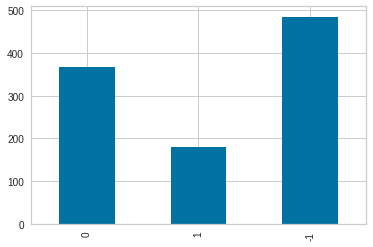

In [10]:
labeled_data.rating.value_counts(sort=False).plot(kind="bar")

-> we have imbalanced (and generally too less) data, therefore up-sampling will be applied after Train/Test split.

## Sentiment Assignment

ML-based approach.

### Train/Test-Split

No need for Dev-Set, as we use cross-validation for model tuning.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.cleaned_txt, labeled_data.rating,
                                                    test_size=0.2, random_state=random_state)

print("X shapes (train/dev/test):", X_train.shape, "/", X_test.shape)
print("y shapes (train/dev/test):", y_train.shape, "/", y_test.shape)

X shapes (train/dev/test): (824,) / (207,)
y shapes (train/dev/test): (824,) / (207,)


#### Up-Sampling

In [12]:
X_samples = pd.concat([X_train, y_train], axis=1)
print(X_samples.shape)
X_samples.rating.value_counts(sort=False)

(824, 2)


-1    386
 1    151
 0    287
Name: rating, dtype: int64

Up-sample positive (2x, with text shuffle and random word skipping)

In [13]:
skip_frac = 0.2 # Fraction of words to be skipped from text during up-sampling

def shuffle_and_skip(txt, frac):
    """ Removes fraction of words in text and shuffles word order. """
    words = txt.split()
    sampled_words = random.sample(words, int(len(words) * (1 - frac)))
    random.shuffle(sampled_words)
    return " ".join(sampled_words)

positive_samples = X_samples[X_samples.rating == 1].copy()
positive_upsamples = pd.concat([positive_samples] * 1, axis=0) # tweks multiplier for more samples
positive_upsamples.cleaned_txt = positive_upsamples.cleaned_txt.apply(lambda x: shuffle_and_skip(x, skip_frac))

X_upsampled = pd.concat([X_samples, positive_upsamples], axis=0)
print(X_upsampled.shape)
X_upsampled.rating.value_counts(sort=False)

(975, 2)


-1    386
 1    302
 0    287
Name: rating, dtype: int64

In [14]:
X_train = X_upsampled.cleaned_txt
y_train = X_upsampled.rating

### Vectorizer

In [15]:
count_vect = CountVectorizer(lowercase=False, # already lowercased
                             tokenizer=word_tokenize,
                             #ngram_range=(1,2),
                             max_features=4000) # tune max_features for generalization eventually, 3gram 25k, 2gram 10k

tfidf = TfidfVectorizer(lowercase=False, # already lowercased
                        tokenizer=word_tokenize,
                        #ngram_range=(1,2),
                        max_features=4000) # tune max_features for generalization eventually, 3gram 25k, 2gram 10k

### Models

In [16]:
logreg = LogisticRegression(penalty="l2", solver="lbfgs", random_state=random_state, n_jobs=1)
nb = MultinomialNB()
rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

models = [logreg, nb, rf]

Parameters

In [17]:
params = {}
params["LogisticRegression"] = {"C": [0.01, 1., 10., 50., 100., 150., 200.],
                                "multi_class": ["ovr", "multinomial"],
                                "class_weight": [None, "balanced"]}
params["MultinomialNB"] = {"alpha": [1.0e-10, 1.],
                           "fit_prior": [True, False]}
params["RandomForestClassifier"] = {"n_estimators": [2, 32, 64, 128],
                                    "criterion": ["gini", "entropy"],
                                    "min_samples_leaf": [1, 2],
                                    "max_features": [None, "auto"],
                                    "class_weight": [None, "balanced"]}

### Pipeline

In [18]:
classifiers = {}

for model in models:
    classifiers[type(model).__name__ + "_pipe"] = Pipeline([
        ("count_vect", count_vect),
        #("tfidf", tfidf),
        ("clf", GridSearchCV(model, param_grid=params[type(model).__name__],
                             scoring="accuracy", cv=8, refit=True, n_jobs=-1))
    ])

Train

In [19]:
for _, clf_pipeline in classifiers.items():
    clf_pipeline.fit(X_train, y_train)

Score

In [20]:
best_score = 0
best_model_pipe = None # = best generalization

for name, clf_pipeline in classifiers.items():
    y_pred = clf_pipeline.predict(X_test)
    scores = cross_validate(clf_pipeline, X_test, y_test, scoring="accuracy", cv=8, n_jobs=1)
    mean_score = scores["test_score"].mean()
    mean_fit_time = scores["fit_time"].mean()
    
    print(name)
    print("Test score (mean):", mean_score)
    print("Test fit time (mean):", mean_fit_time)
    print("Train score:", clf_pipeline.named_steps["clf"].best_score_)
    print("Params:", clf_pipeline.named_steps["clf"].best_params_, "\n")
    
    if mean_score > best_score:
        best_model_pipe = clf_pipeline
        best_score = mean_score

LogisticRegression_pipe
Test score (mean): 0.5074928774928775
Test fit time (mean): 3.085983455181122
Train score: 0.6235897435897436
Params: {'C': 1.0, 'class_weight': None, 'multi_class': 'multinomial'} 

MultinomialNB_pipe
Test score (mean): 0.44344017094017096
Test fit time (mean): 0.08677434921264648
Train score: 0.6523076923076923
Params: {'alpha': 1e-10, 'fit_prior': False} 

RandomForestClassifier_pipe
Test score (mean): 0.4354558404558404
Test fit time (mean): 31.43960303068161
Train score: 0.563076923076923
Params: {'class_weight': None, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 64} 



In [28]:
#len(best_model_pipe.named_steps["count_vect"].get_feature_names())
#best_model_pipe.named_steps["count_vect"].get_feature_names()

## Evaluation

In [40]:
print("Best pipeline CLF:", best_model_pipe.named_steps["clf"].best_estimator_)

Best pipeline CLF: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=1, penalty='l2',
                   random_state=23, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [22]:
class_encoding = {1: "positive", 0: "neutral", -1: "negative"}

#### Confusion Matrix

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


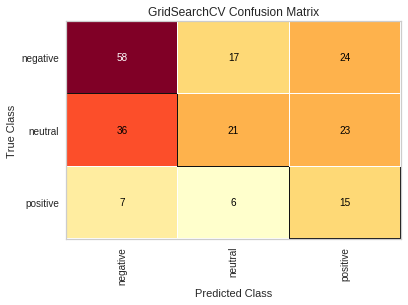

In [23]:
cm = ConfusionMatrix(best_model_pipe, is_fitted=True, encoder=class_encoding)
cm.score(X_test, y_test)
cm.poof()

#### Classification Report

              precision    recall  f1-score   support

          -1       0.57      0.59      0.58        99
           0       0.48      0.26      0.34        80
           1       0.24      0.54      0.33        28

    accuracy                           0.45       207
   macro avg       0.43      0.46      0.42       207
weighted avg       0.49      0.45      0.45       207



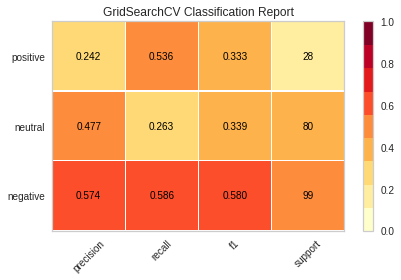

In [24]:
print(classification_report(y_test, best_model_pipe.predict(X_test)))

# Visualizer
report = ClassificationReport(best_model_pipe, is_fitted=True, encoder=class_encoding, support=True)
report.score(X_test, y_test)
report.poof()

#### Precision-Recall Curve

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


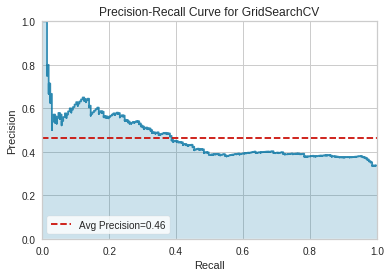

In [25]:
pr_curve = PrecisionRecallCurve(best_model_pipe)
pr_curve.fit(X_train, y_train)
pr_curve.score(X_test, y_test)
pr_curve.poof()

#### ROCAUC

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


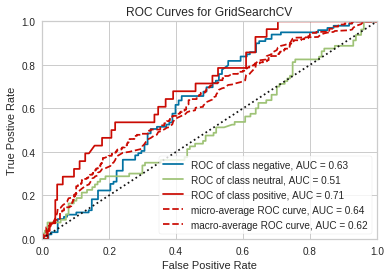

In [26]:
rocauc = ROCAUC(best_model_pipe, is_fitted=True, encoder=class_encoding)
rocauc.score(X_test, y_test)
rocauc.poof()

# Conclusion

